In [59]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from jinja2 import Template
import re

from dotenv import load_dotenv
load_dotenv(override=True)

root_dir = os.environ.get("ROOT_PATH")
if not root_dir in sys.path: sys.path.append(root_dir)

from src.utils.constants import *
from src.utils.CosmoFunc import *
from src.utils.logging_config import get_logger
from src.filepaths import *

# Get environment variables from .env file
ROOT_PATH = os.environ.get('ROOT_PATH')
SMIN_SETTING = int(os.environ.get('SMIN_SETTING'))
COMPLETENESS_SETTING = int(os.environ.get('COMPLETENESS_SETTING'))
FP_FIT_METHOD = int(os.environ.get('FP_FIT_METHOD'))

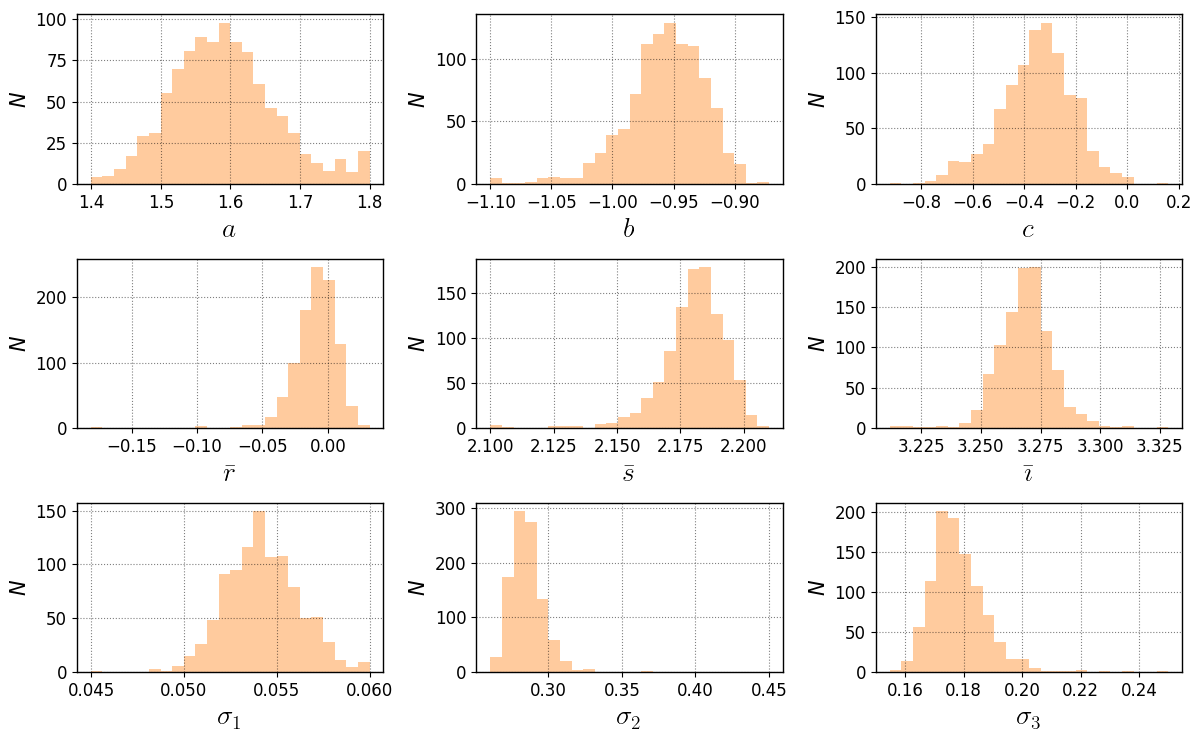

In [82]:
def remove_outliers(x, k=5.0):
    # Select inliers using MAD
    median_x = np.median(x)
    MAD_x = np.median(np.absolute(x - median_x))
    lower_ = median_x - k * MAD_x
    upper_ = median_x + k * MAD_x
    x_inliers = x[(x >= lower_) & (x <= upper_)]

    # Calculate standard deviation using the assumed inliers
    mean_ = np.mean(x_inliers)
    std_ = np.std(x_inliers)
    lower_ = mean_ - 5 * std_
    upper_ = mean_ + 5 * std_

    # Define outliers as 5 sigma away from the mean
    x_outliers = x[(x < lower_) | (x > upper_)]
    return x_inliers, x_outliers


mpl.rcParams['axes.linewidth'] = 1.0

survey = "LAMOST"

df = pd.read_csv(os.path.join(ROOT_PATH, f"artifacts/mock_fits/smin_setting_1/fp_fit_method_1/{survey.lower()}_fit_with_partial_fn.csv"))
df["c"] = df["rmean"] - df["a"] * df["smean"] - df["b"] * df["imean"]

# Columns to plot
columns_ = ["a", "b", "c", "rmean", "smean", "imean", "sigma1", "sigma2", "sigma3"]
labels_ = [r'$a$', r'$b$', r"$c$", r'$\bar{r}$', r'$\bar{s}$', r'$\bar{\imath}$', r'$\sigma_1$', r'$\sigma_2$', r'$\sigma_3$']

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(FIGURE_WIDTH * 3 / 2, FIGURE_HEIGHT * 3 / 2))
for i, ax in enumerate(fig.axes):
    col = columns_[i]
    raw_partial_fn = df[col].to_numpy()

    partial_fn, partial_fn_outliers = remove_outliers(raw_partial_fn)

    # Create bins
    left_ = np.min(raw_partial_fn)
    right_ = np.max(raw_partial_fn)
    bins_ = np.linspace(left_, right_, 25)

    # Plot the histograms
    ax.hist(raw_partial_fn, bins=bins_, density=False, alpha=0.4, color='C1')

    # Labels
    ax.set_xlabel(labels_[i], fontsize=20, usetex=True, family="sans-serif")
    ax.set_ylabel(r"$N$", fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(ls=":", color='k', alpha=0.5)
    # if col=="sigma1":
    #     ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=4))
    # ax.legend()

fig.tight_layout()
# fig.savefig('../img/final_plot/fig_7_lamost_mocks.pdf', bbox_inches='tight', dpi=300)

In [27]:
FP_COLUMNS = ["a", "b", "rmean", "smean", "imean", "sigma1", "sigma2", "sigma3"]

# Load data (MCMC chain) measurements
data = np.load("../artifacts/fp_fit/smin_setting_1/fp_fit_method_0/6dfgs_chain.npy")
df_data = pd.DataFrame(data, columns=FP_COLUMNS)

for col in FP_COLUMNS:
    x = df_data[col].to_numpy()

    x, _ = remove_outliers(x)

    mean = np.round(np.mean(x), 3)
    std = np.round(np.std(x), 3)

    print(f"{col} = {mean} ± {std}")

a = 1.421 ± 0.02
b = -0.869 ± 0.007
rmean = 0.189 ± 0.004
smean = 2.258 ± 0.002
imean = 3.212 ± 0.003
sigma1 = 0.042 ± 0.001
sigma2 = 0.287 ± 0.003
sigma3 = 0.147 ± 0.002


In [63]:
FP_COLUMNS = ["a", "b", "rmean", "smean", "imean", "sigma1", "sigma2", "sigma3"]

jinja_context = {}
for survey in (SURVEY_LIST + ["ALL_COMBINED"]):

    for fp_fit_method in [0, 1]:

        method_ = "full_fn" if fp_fit_method == 0 else "partial_fn"

        # Load data (MCMC chain) measurements
        type_ = "data"
        survey_lowercase = survey.lower()

        # Load data (MCMC chain) measurements
        data = np.load(f"../artifacts/fp_fit/smin_setting_1/fp_fit_method_{fp_fit_method}/{survey_lowercase}_chain.npy")
        df_data = pd.DataFrame(data, columns=FP_COLUMNS)

        for col in FP_COLUMNS:
            x = df_data[col].to_numpy()

            x, _ = remove_outliers(x)

            mean = f"{np.round(np.mean(x), 3):.3f}"
            std = f"{np.round(np.std(x), 3):.3f}"

            jinja_context[f"{type_}_{survey_lowercase}_{col}_{method_}_mean"] = mean
            jinja_context[f"{type_}_{survey_lowercase}_{col}_{method_}_std"] = std


        # Load mock fits
        type_ = "mock"
        survey_lowercase = survey.lower()

        # Load data (MCMC chain) measurements
        df_mock = pd.read_csv(f"../artifacts/mock_fits/smin_setting_1/fp_fit_method_{fp_fit_method}/{survey_lowercase}_fit_with_{method_}.csv")

        for col in FP_COLUMNS:
            x = df_mock[col].to_numpy()

            x, _ = remove_outliers(x)

            mean = f"{np.round(np.mean(x), 3):.3f}"
            std = f"{np.round(np.std(x), 3):.3f}"

            jinja_context[f"{type_}_{survey_lowercase}_{col}_{method_}_mean"] = mean
            jinja_context[f"{type_}_{survey_lowercase}_{col}_{method_}_std"] = std

jinja_context

{'data_6dfgs_a_full_fn_mean': '1.421',
 'data_6dfgs_a_full_fn_std': '0.020',
 'data_6dfgs_b_full_fn_mean': '-0.869',
 'data_6dfgs_b_full_fn_std': '0.007',
 'data_6dfgs_rmean_full_fn_mean': '0.189',
 'data_6dfgs_rmean_full_fn_std': '0.004',
 'data_6dfgs_smean_full_fn_mean': '2.258',
 'data_6dfgs_smean_full_fn_std': '0.002',
 'data_6dfgs_imean_full_fn_mean': '3.212',
 'data_6dfgs_imean_full_fn_std': '0.003',
 'data_6dfgs_sigma1_full_fn_mean': '0.042',
 'data_6dfgs_sigma1_full_fn_std': '0.001',
 'data_6dfgs_sigma2_full_fn_mean': '0.287',
 'data_6dfgs_sigma2_full_fn_std': '0.003',
 'data_6dfgs_sigma3_full_fn_mean': '0.147',
 'data_6dfgs_sigma3_full_fn_std': '0.002',
 'mock_6dfgs_a_full_fn_mean': '1.419',
 'mock_6dfgs_a_full_fn_std': '0.021',
 'mock_6dfgs_b_full_fn_mean': '-0.869',
 'mock_6dfgs_b_full_fn_std': '0.007',
 'mock_6dfgs_rmean_full_fn_mean': '0.189',
 'mock_6dfgs_rmean_full_fn_std': '0.004',
 'mock_6dfgs_smean_full_fn_mean': '2.258',
 'mock_6dfgs_smean_full_fn_std': '0.002',
 'mo

### Template to generate all surveys

In [69]:
table_template = r"""
\begin{table*}[]
\begin{tabular}{lllllllll}
               & \multicolumn{2}{l}{6dFGS}                                                                                                                                       & \multicolumn{2}{l}{SDSS}                                                                                                                                    & \multicolumn{2}{l}{LAMOST}                                                                                                                                          & \multicolumn{2}{l}{Combined}                                                                                                                                                                \\
Parameter      & Data                                                                           & Mock                                                                           & Data                                                                         & Mock                                                                         & Data                                                                             & Mock                                                                             & Data                                                                                         & Mock                                                                                         \\
$a$            & ${{ data_6dfgs_a_full_fn_mean }} \pm {{ data_6dfgs_a_full_fn_std }}$           & ${{ mock_6dfgs_a_full_fn_mean }} \pm {{ mock_6dfgs_a_full_fn_std }}$           & ${{ data_sdss_a_full_fn_mean }} \pm {{ data_sdss_a_full_fn_std }}$           & ${{ mock_sdss_a_full_fn_mean }} \pm {{ mock_sdss_a_full_fn_std }}$           & ${{ data_lamost_a_full_fn_mean }} \pm {{ data_lamost_a_full_fn_std }}$           & ${{ mock_lamost_a_full_fn_mean }} \pm {{ mock_lamost_a_full_fn_std }}$           & ${{ data_all_combined_a_full_fn_mean }} \pm {{ data_all_combined_a_full_fn_std }}$           & ${{ mock_all_combined_a_full_fn_mean }} \pm {{ mock_all_combined_a_full_fn_std }}$           \\
$b$            & ${{ data_6dfgs_b_full_fn_mean }} \pm {{ data_6dfgs_b_full_fn_std }}$           & ${{ mock_6dfgs_b_full_fn_mean }} \pm {{ mock_6dfgs_b_full_fn_std }}$           & ${{ data_sdss_b_full_fn_mean }} \pm {{ data_sdss_b_full_fn_std }}$           & ${{ mock_sdss_b_full_fn_mean }} \pm {{ mock_sdss_b_full_fn_std }}$           & ${{ data_lamost_b_full_fn_mean }} \pm {{ data_lamost_b_full_fn_std }}$           & ${{ mock_lamost_b_full_fn_mean }} \pm {{ mock_lamost_b_full_fn_std }}$           & ${{ data_all_combined_b_full_fn_mean }} \pm {{ data_all_combined_b_full_fn_std }}$           & ${{ mock_all_combined_b_full_fn_mean }} \pm {{ mock_all_combined_b_full_fn_std }}$           \\
$\bar{r}$      & ${{ data_6dfgs_rmean_full_fn_mean }} \pm {{ data_6dfgs_rmean_full_fn_std }}$   & ${{ mock_6dfgs_rmean_full_fn_mean }} \pm {{ mock_6dfgs_rmean_full_fn_std }}$   & ${{ data_sdss_rmean_full_fn_mean }} \pm {{ data_sdss_rmean_full_fn_std }}$   & ${{ mock_sdss_rmean_full_fn_mean }} \pm {{ mock_sdss_rmean_full_fn_std }}$   & ${{ data_lamost_rmean_full_fn_mean }} \pm {{ data_lamost_rmean_full_fn_std }}$   & ${{ mock_lamost_rmean_full_fn_mean }} \pm {{ mock_lamost_rmean_full_fn_std }}$   & ${{ data_all_combined_rmean_full_fn_mean }} \pm {{ data_all_combined_rmean_full_fn_std }}$   & ${{ mock_all_combined_rmean_full_fn_mean }} \pm {{ mock_all_combined_rmean_full_fn_std }}$   \\
$\bar{s}$      & ${{ data_6dfgs_smean_full_fn_mean }} \pm {{ data_6dfgs_smean_full_fn_std }}$   & ${{ mock_6dfgs_smean_full_fn_mean }} \pm {{ mock_6dfgs_smean_full_fn_std }}$   & ${{ data_sdss_smean_full_fn_mean }} \pm {{ data_sdss_smean_full_fn_std }}$   & ${{ mock_sdss_smean_full_fn_mean }} \pm {{ mock_sdss_smean_full_fn_std }}$   & ${{ data_lamost_smean_full_fn_mean }} \pm {{ data_lamost_smean_full_fn_std }}$   & ${{ mock_lamost_smean_full_fn_mean }} \pm {{ mock_lamost_smean_full_fn_std }}$   & ${{ data_all_combined_smean_full_fn_mean }} \pm {{ data_all_combined_smean_full_fn_std }}$   & ${{ mock_all_combined_smean_full_fn_mean }} \pm {{ mock_all_combined_smean_full_fn_std }}$   \\
$\bar{\imath}$ & ${{ data_6dfgs_imean_full_fn_mean }} \pm {{ data_6dfgs_imean_full_fn_std }}$   & ${{ mock_6dfgs_imean_full_fn_mean }} \pm {{ mock_6dfgs_imean_full_fn_std }}$   & ${{ data_sdss_imean_full_fn_mean }} \pm {{ data_sdss_imean_full_fn_std }}$   & ${{ mock_sdss_imean_full_fn_mean }} \pm {{ mock_sdss_imean_full_fn_std }}$   & ${{ data_lamost_imean_full_fn_mean }} \pm {{ data_lamost_imean_full_fn_std }}$   & ${{ mock_lamost_imean_full_fn_mean }} \pm {{ mock_lamost_imean_full_fn_std }}$   & ${{ data_all_combined_imean_full_fn_mean }} \pm {{ data_all_combined_imean_full_fn_std }}$   & ${{ mock_all_combined_imean_full_fn_mean }} \pm {{ mock_all_combined_imean_full_fn_std }}$   \\
$\sigma_1$     & ${{ data_6dfgs_sigma1_full_fn_mean }} \pm {{ data_6dfgs_sigma1_full_fn_std }}$ & ${{ mock_6dfgs_sigma1_full_fn_mean }} \pm {{ mock_6dfgs_sigma1_full_fn_std }}$ & ${{ data_sdss_sigma1_full_fn_mean }} \pm {{ data_sdss_sigma1_full_fn_std }}$ & ${{ mock_sdss_sigma1_full_fn_mean }} \pm {{ mock_sdss_sigma1_full_fn_std }}$ & ${{ data_lamost_sigma1_full_fn_mean }} \pm {{ data_lamost_sigma1_full_fn_std }}$ & ${{ mock_lamost_sigma1_full_fn_mean }} \pm {{ mock_lamost_sigma1_full_fn_std }}$ & ${{ data_all_combined_sigma1_full_fn_mean }} \pm {{ data_all_combined_sigma1_full_fn_std }}$ & ${{ mock_all_combined_sigma1_full_fn_mean }} \pm {{ mock_all_combined_sigma1_full_fn_std }}$ \\
$\sigma_2$     & ${{ data_6dfgs_sigma2_full_fn_mean }} \pm {{ data_6dfgs_sigma2_full_fn_std }}$ & ${{ mock_6dfgs_sigma2_full_fn_mean }} \pm {{ mock_6dfgs_sigma2_full_fn_std }}$ & ${{ data_sdss_sigma2_full_fn_mean }} \pm {{ data_sdss_sigma2_full_fn_std }}$ & ${{ mock_sdss_sigma2_full_fn_mean }} \pm {{ mock_sdss_sigma2_full_fn_std }}$ & ${{ data_lamost_sigma2_full_fn_mean }} \pm {{ data_lamost_sigma2_full_fn_std }}$ & ${{ mock_lamost_sigma2_full_fn_mean }} \pm {{ mock_lamost_sigma2_full_fn_std }}$ & ${{ data_all_combined_sigma2_full_fn_mean }} \pm {{ data_all_combined_sigma2_full_fn_std }}$ & ${{ mock_all_combined_sigma2_full_fn_mean }} \pm {{ mock_all_combined_sigma2_full_fn_std }}$ \\
$\sigma_3$     & ${{ data_6dfgs_sigma3_full_fn_mean }} \pm {{ data_6dfgs_sigma3_full_fn_std }}$ & ${{ mock_6dfgs_sigma3_full_fn_mean }} \pm {{ mock_6dfgs_sigma3_full_fn_std }}$ & ${{ data_sdss_sigma3_full_fn_mean }} \pm {{ data_sdss_sigma3_full_fn_std }}$ & ${{ mock_sdss_sigma3_full_fn_mean }} \pm {{ mock_sdss_sigma3_full_fn_std }}$ & ${{ data_lamost_sigma3_full_fn_mean }} \pm {{ data_lamost_sigma3_full_fn_std }}$ & ${{ mock_lamost_sigma3_full_fn_mean }} \pm {{ mock_lamost_sigma3_full_fn_std }}$ & ${{ data_all_combined_sigma3_full_fn_mean }} \pm {{ data_all_combined_sigma3_full_fn_std }}$ & ${{ mock_all_combined_sigma3_full_fn_mean }} \pm {{ mock_all_combined_sigma3_full_fn_std }}$
\end{tabular}
\end{table*}
"""

regex_result = result = re.sub(r'[ ]{2,}', ' ', table_template)
print(regex_result)


\begin{table*}[]
\begin{tabular}{lllllllll}
 & \multicolumn{2}{l}{6dFGS} & \multicolumn{2}{l}{SDSS} & \multicolumn{2}{l}{LAMOST} & \multicolumn{2}{l}{Combined} \\
Parameter & Data & Mock & Data & Mock & Data & Mock & Data & Mock \\
$a$ & ${{ data_6dfgs_a_full_fn_mean }} \pm {{ data_6dfgs_a_full_fn_std }}$ & ${{ mock_6dfgs_a_full_fn_mean }} \pm {{ mock_6dfgs_a_full_fn_std }}$ & ${{ data_sdss_a_full_fn_mean }} \pm {{ data_sdss_a_full_fn_std }}$ & ${{ mock_sdss_a_full_fn_mean }} \pm {{ mock_sdss_a_full_fn_std }}$ & ${{ data_lamost_a_full_fn_mean }} \pm {{ data_lamost_a_full_fn_std }}$ & ${{ mock_lamost_a_full_fn_mean }} \pm {{ mock_lamost_a_full_fn_std }}$ & ${{ data_all_combined_a_full_fn_mean }} \pm {{ data_all_combined_a_full_fn_std }}$ & ${{ mock_all_combined_a_full_fn_mean }} \pm {{ mock_all_combined_a_full_fn_std }}$ \\
$b$ & ${{ data_6dfgs_b_full_fn_mean }} \pm {{ data_6dfgs_b_full_fn_std }}$ & ${{ mock_6dfgs_b_full_fn_mean }} \pm {{ mock_6dfgs_b_full_fn_std }}$ & ${{ data_sdss_b_

### Render the template for the full $f_n$ measurements

In [65]:
table_template = r"""
\begin{table*}[]
\begin{tabular}{lllllllll}
\hline \\
 & \multicolumn{2}{c}{6dFGS} & \multicolumn{2}{c}{SDSS} & \multicolumn{2}{c}{LAMOST} & \multicolumn{2}{c}{Combined} \\ \hline
Parameter & Data & Mock & Data & Mock & Data & Mock & Data & Mock \\ \hline
$a$ & ${{ data_6dfgs_a_full_fn_mean }} \pm {{ data_6dfgs_a_full_fn_std }}$ & ${{ mock_6dfgs_a_full_fn_mean }} \pm {{ mock_6dfgs_a_full_fn_std }}$ & ${{ data_sdss_a_full_fn_mean }} \pm {{ data_sdss_a_full_fn_std }}$ & ${{ mock_sdss_a_full_fn_mean }} \pm {{ mock_sdss_a_full_fn_std }}$ & ${{ data_lamost_a_full_fn_mean }} \pm {{ data_lamost_a_full_fn_std }}$ & ${{ mock_lamost_a_full_fn_mean }} \pm {{ mock_lamost_a_full_fn_std }}$ & ${{ data_all_combined_a_full_fn_mean }} \pm {{ data_all_combined_a_full_fn_std }}$ & ${{ mock_all_combined_a_full_fn_mean }} \pm {{ mock_all_combined_a_full_fn_std }}$ \\
$b$ & ${{ data_6dfgs_b_full_fn_mean }} \pm {{ data_6dfgs_b_full_fn_std }}$ & ${{ mock_6dfgs_b_full_fn_mean }} \pm {{ mock_6dfgs_b_full_fn_std }}$ & ${{ data_sdss_b_full_fn_mean }} \pm {{ data_sdss_b_full_fn_std }}$ & ${{ mock_sdss_b_full_fn_mean }} \pm {{ mock_sdss_b_full_fn_std }}$ & ${{ data_lamost_b_full_fn_mean }} \pm {{ data_lamost_b_full_fn_std }}$ & ${{ mock_lamost_b_full_fn_mean }} \pm {{ mock_lamost_b_full_fn_std }}$ & ${{ data_all_combined_b_full_fn_mean }} \pm {{ data_all_combined_b_full_fn_std }}$ & ${{ mock_all_combined_b_full_fn_mean }} \pm {{ mock_all_combined_b_full_fn_std }}$ \\
$\bar{r}$ & ${{ data_6dfgs_rmean_full_fn_mean }} \pm {{ data_6dfgs_rmean_full_fn_std }}$ & ${{ mock_6dfgs_rmean_full_fn_mean }} \pm {{ mock_6dfgs_rmean_full_fn_std }}$ & ${{ data_sdss_rmean_full_fn_mean }} \pm {{ data_sdss_rmean_full_fn_std }}$ & ${{ mock_sdss_rmean_full_fn_mean }} \pm {{ mock_sdss_rmean_full_fn_std }}$ & ${{ data_lamost_rmean_full_fn_mean }} \pm {{ data_lamost_rmean_full_fn_std }}$ & ${{ mock_lamost_rmean_full_fn_mean }} \pm {{ mock_lamost_rmean_full_fn_std }}$ & ${{ data_all_combined_rmean_full_fn_mean }} \pm {{ data_all_combined_rmean_full_fn_std }}$ & ${{ mock_all_combined_rmean_full_fn_mean }} \pm {{ mock_all_combined_rmean_full_fn_std }}$ \\
$\bar{s}$ & ${{ data_6dfgs_smean_full_fn_mean }} \pm {{ data_6dfgs_smean_full_fn_std }}$ & ${{ mock_6dfgs_smean_full_fn_mean }} \pm {{ mock_6dfgs_smean_full_fn_std }}$ & ${{ data_sdss_smean_full_fn_mean }} \pm {{ data_sdss_smean_full_fn_std }}$ & ${{ mock_sdss_smean_full_fn_mean }} \pm {{ mock_sdss_smean_full_fn_std }}$ & ${{ data_lamost_smean_full_fn_mean }} \pm {{ data_lamost_smean_full_fn_std }}$ & ${{ mock_lamost_smean_full_fn_mean }} \pm {{ mock_lamost_smean_full_fn_std }}$ & ${{ data_all_combined_smean_full_fn_mean }} \pm {{ data_all_combined_smean_full_fn_std }}$ & ${{ mock_all_combined_smean_full_fn_mean }} \pm {{ mock_all_combined_smean_full_fn_std }}$ \\
$\bar{\imath}$ & ${{ data_6dfgs_imean_full_fn_mean }} \pm {{ data_6dfgs_imean_full_fn_std }}$ & ${{ mock_6dfgs_imean_full_fn_mean }} \pm {{ mock_6dfgs_imean_full_fn_std }}$ & ${{ data_sdss_imean_full_fn_mean }} \pm {{ data_sdss_imean_full_fn_std }}$ & ${{ mock_sdss_imean_full_fn_mean }} \pm {{ mock_sdss_imean_full_fn_std }}$ & ${{ data_lamost_imean_full_fn_mean }} \pm {{ data_lamost_imean_full_fn_std }}$ & ${{ mock_lamost_imean_full_fn_mean }} \pm {{ mock_lamost_imean_full_fn_std }}$ & ${{ data_all_combined_imean_full_fn_mean }} \pm {{ data_all_combined_imean_full_fn_std }}$ & ${{ mock_all_combined_imean_full_fn_mean }} \pm {{ mock_all_combined_imean_full_fn_std }}$ \\
$\sigma_1$ & ${{ data_6dfgs_sigma1_full_fn_mean }} \pm {{ data_6dfgs_sigma1_full_fn_std }}$ & ${{ mock_6dfgs_sigma1_full_fn_mean }} \pm {{ mock_6dfgs_sigma1_full_fn_std }}$ & ${{ data_sdss_sigma1_full_fn_mean }} \pm {{ data_sdss_sigma1_full_fn_std }}$ & ${{ mock_sdss_sigma1_full_fn_mean }} \pm {{ mock_sdss_sigma1_full_fn_std }}$ & ${{ data_lamost_sigma1_full_fn_mean }} \pm {{ data_lamost_sigma1_full_fn_std }}$ & ${{ mock_lamost_sigma1_full_fn_mean }} \pm {{ mock_lamost_sigma1_full_fn_std }}$ & ${{ data_all_combined_sigma1_full_fn_mean }} \pm {{ data_all_combined_sigma1_full_fn_std }}$ & ${{ mock_all_combined_sigma1_full_fn_mean }} \pm {{ mock_all_combined_sigma1_full_fn_std }}$ \\
$\sigma_2$ & ${{ data_6dfgs_sigma2_full_fn_mean }} \pm {{ data_6dfgs_sigma2_full_fn_std }}$ & ${{ mock_6dfgs_sigma2_full_fn_mean }} \pm {{ mock_6dfgs_sigma2_full_fn_std }}$ & ${{ data_sdss_sigma2_full_fn_mean }} \pm {{ data_sdss_sigma2_full_fn_std }}$ & ${{ mock_sdss_sigma2_full_fn_mean }} \pm {{ mock_sdss_sigma2_full_fn_std }}$ & ${{ data_lamost_sigma2_full_fn_mean }} \pm {{ data_lamost_sigma2_full_fn_std }}$ & ${{ mock_lamost_sigma2_full_fn_mean }} \pm {{ mock_lamost_sigma2_full_fn_std }}$ & ${{ data_all_combined_sigma2_full_fn_mean }} \pm {{ data_all_combined_sigma2_full_fn_std }}$ & ${{ mock_all_combined_sigma2_full_fn_mean }} \pm {{ mock_all_combined_sigma2_full_fn_std }}$ \\
$\sigma_3$ & ${{ data_6dfgs_sigma3_full_fn_mean }} \pm {{ data_6dfgs_sigma3_full_fn_std }}$ & ${{ mock_6dfgs_sigma3_full_fn_mean }} \pm {{ mock_6dfgs_sigma3_full_fn_std }}$ & ${{ data_sdss_sigma3_full_fn_mean }} \pm {{ data_sdss_sigma3_full_fn_std }}$ & ${{ mock_sdss_sigma3_full_fn_mean }} \pm {{ mock_sdss_sigma3_full_fn_std }}$ & ${{ data_lamost_sigma3_full_fn_mean }} \pm {{ data_lamost_sigma3_full_fn_std }}$ & ${{ mock_lamost_sigma3_full_fn_mean }} \pm {{ mock_lamost_sigma3_full_fn_std }}$ & ${{ data_all_combined_sigma3_full_fn_mean }} \pm {{ data_all_combined_sigma3_full_fn_std }}$ & ${{ mock_all_combined_sigma3_full_fn_mean }} \pm {{ mock_all_combined_sigma3_full_fn_std }}$ \\ \hline
\end{tabular}
\end{table*}
"""

print(Template(table_template).render(jinja_context))


\begin{table*}[]
\begin{tabular}{lllllllll}
\hline \\
 & \multicolumn{2}{c}{6dFGS} & \multicolumn{2}{c}{SDSS} & \multicolumn{2}{c}{LAMOST} & \multicolumn{2}{c}{Combined} \\ \hline
Parameter & Data & Mock & Data & Mock & Data & Mock & Data & Mock \\ \hline
$a$ & $1.421 \pm 0.020$ & $1.419 \pm 0.021$ & $1.439 \pm 0.017$ & $1.439 \pm 0.019$ & $1.459 \pm 0.036$ & $1.459 \pm 0.040$ & $1.449 \pm 0.012$ & $1.449 \pm 0.013$ \\
$b$ & $-0.869 \pm 0.007$ & $-0.869 \pm 0.007$ & $-0.899 \pm 0.008$ & $-0.899 \pm 0.008$ & $-0.919 \pm 0.015$ & $-0.918 \pm 0.014$ & $-0.895 \pm 0.005$ & $-0.895 \pm 0.005$ \\
$\bar{r}$ & $0.189 \pm 0.004$ & $0.189 \pm 0.004$ & $0.156 \pm 0.005$ & $0.156 \pm 0.005$ & $-0.045 \pm 0.010$ & $-0.043 \pm 0.009$ & $0.141 \pm 0.003$ & $0.141 \pm 0.003$ \\
$\bar{s}$ & $2.258 \pm 0.002$ & $2.258 \pm 0.002$ & $2.237 \pm 0.003$ & $2.238 \pm 0.003$ & $2.166 \pm 0.008$ & $2.167 \pm 0.008$ & $2.240 \pm 0.002$ & $2.241 \pm 0.002$ \\
$\bar{\imath}$ & $3.212 \pm 0.003$ & $3.212 \pm 0.004

### Render the template for the partial $f_n$ measurements

In [70]:
table_template = r"""
\begin{table*}[]
\begin{tabular}{lllllllll}
\hline \\
 & \multicolumn{2}{c}{6dFGS} & \multicolumn{2}{c}{SDSS} & \multicolumn{2}{c}{LAMOST} & \multicolumn{2}{c}{Combined} \\ \hline
Parameter & Data & Mock & Data & Mock & Data & Mock & Data & Mock \\ \hline
$a$ & ${{ data_6dfgs_a_partial_fn_mean }} \pm {{ data_6dfgs_a_partial_fn_std }}$ & ${{ mock_6dfgs_a_partial_fn_mean }} \pm {{ mock_6dfgs_a_partial_fn_std }}$ & ${{ data_sdss_a_partial_fn_mean }} \pm {{ data_sdss_a_partial_fn_std }}$ & ${{ mock_sdss_a_partial_fn_mean }} \pm {{ mock_sdss_a_partial_fn_std }}$ & ${{ data_lamost_a_partial_fn_mean }} \pm {{ data_lamost_a_partial_fn_std }}$ & ${{ mock_lamost_a_partial_fn_mean }} \pm {{ mock_lamost_a_partial_fn_std }}$ & ${{ data_all_combined_a_partial_fn_mean }} \pm {{ data_all_combined_a_partial_fn_std }}$ & ${{ mock_all_combined_a_partial_fn_mean }} \pm {{ mock_all_combined_a_partial_fn_std }}$ \\
$b$ & ${{ data_6dfgs_b_partial_fn_mean }} \pm {{ data_6dfgs_b_partial_fn_std }}$ & ${{ mock_6dfgs_b_partial_fn_mean }} \pm {{ mock_6dfgs_b_partial_fn_std }}$ & ${{ data_sdss_b_partial_fn_mean }} \pm {{ data_sdss_b_partial_fn_std }}$ & ${{ mock_sdss_b_partial_fn_mean }} \pm {{ mock_sdss_b_partial_fn_std }}$ & ${{ data_lamost_b_partial_fn_mean }} \pm {{ data_lamost_b_partial_fn_std }}$ & ${{ mock_lamost_b_partial_fn_mean }} \pm {{ mock_lamost_b_partial_fn_std }}$ & ${{ data_all_combined_b_partial_fn_mean }} \pm {{ data_all_combined_b_partial_fn_std }}$ & ${{ mock_all_combined_b_partial_fn_mean }} \pm {{ mock_all_combined_b_partial_fn_std }}$ \\
$\bar{r}$ & ${{ data_6dfgs_rmean_partial_fn_mean }} \pm {{ data_6dfgs_rmean_partial_fn_std }}$ & ${{ mock_6dfgs_rmean_partial_fn_mean }} \pm {{ mock_6dfgs_rmean_partial_fn_std }}$ & ${{ data_sdss_rmean_partial_fn_mean }} \pm {{ data_sdss_rmean_partial_fn_std }}$ & ${{ mock_sdss_rmean_partial_fn_mean }} \pm {{ mock_sdss_rmean_partial_fn_std }}$ & ${{ data_lamost_rmean_partial_fn_mean }} \pm {{ data_lamost_rmean_partial_fn_std }}$ & ${{ mock_lamost_rmean_partial_fn_mean }} \pm {{ mock_lamost_rmean_partial_fn_std }}$ & ${{ data_all_combined_rmean_partial_fn_mean }} \pm {{ data_all_combined_rmean_partial_fn_std }}$ & ${{ mock_all_combined_rmean_partial_fn_mean }} \pm {{ mock_all_combined_rmean_partial_fn_std }}$ \\
$\bar{s}$ & ${{ data_6dfgs_smean_partial_fn_mean }} \pm {{ data_6dfgs_smean_partial_fn_std }}$ & ${{ mock_6dfgs_smean_partial_fn_mean }} \pm {{ mock_6dfgs_smean_partial_fn_std }}$ & ${{ data_sdss_smean_partial_fn_mean }} \pm {{ data_sdss_smean_partial_fn_std }}$ & ${{ mock_sdss_smean_partial_fn_mean }} \pm {{ mock_sdss_smean_partial_fn_std }}$ & ${{ data_lamost_smean_partial_fn_mean }} \pm {{ data_lamost_smean_partial_fn_std }}$ & ${{ mock_lamost_smean_partial_fn_mean }} \pm {{ mock_lamost_smean_partial_fn_std }}$ & ${{ data_all_combined_smean_partial_fn_mean }} \pm {{ data_all_combined_smean_partial_fn_std }}$ & ${{ mock_all_combined_smean_partial_fn_mean }} \pm {{ mock_all_combined_smean_partial_fn_std }}$ \\
$\bar{\imath}$ & ${{ data_6dfgs_imean_partial_fn_mean }} \pm {{ data_6dfgs_imean_partial_fn_std }}$ & ${{ mock_6dfgs_imean_partial_fn_mean }} \pm {{ mock_6dfgs_imean_partial_fn_std }}$ & ${{ data_sdss_imean_partial_fn_mean }} \pm {{ data_sdss_imean_partial_fn_std }}$ & ${{ mock_sdss_imean_partial_fn_mean }} \pm {{ mock_sdss_imean_partial_fn_std }}$ & ${{ data_lamost_imean_partial_fn_mean }} \pm {{ data_lamost_imean_partial_fn_std }}$ & ${{ mock_lamost_imean_partial_fn_mean }} \pm {{ mock_lamost_imean_partial_fn_std }}$ & ${{ data_all_combined_imean_partial_fn_mean }} \pm {{ data_all_combined_imean_partial_fn_std }}$ & ${{ mock_all_combined_imean_partial_fn_mean }} \pm {{ mock_all_combined_imean_partial_fn_std }}$ \\
$\sigma_1$ & ${{ data_6dfgs_sigma1_partial_fn_mean }} \pm {{ data_6dfgs_sigma1_partial_fn_std }}$ & ${{ mock_6dfgs_sigma1_partial_fn_mean }} \pm {{ mock_6dfgs_sigma1_partial_fn_std }}$ & ${{ data_sdss_sigma1_partial_fn_mean }} \pm {{ data_sdss_sigma1_partial_fn_std }}$ & ${{ mock_sdss_sigma1_partial_fn_mean }} \pm {{ mock_sdss_sigma1_partial_fn_std }}$ & ${{ data_lamost_sigma1_partial_fn_mean }} \pm {{ data_lamost_sigma1_partial_fn_std }}$ & ${{ mock_lamost_sigma1_partial_fn_mean }} \pm {{ mock_lamost_sigma1_partial_fn_std }}$ & ${{ data_all_combined_sigma1_partial_fn_mean }} \pm {{ data_all_combined_sigma1_partial_fn_std }}$ & ${{ mock_all_combined_sigma1_partial_fn_mean }} \pm {{ mock_all_combined_sigma1_partial_fn_std }}$ \\
$\sigma_2$ & ${{ data_6dfgs_sigma2_partial_fn_mean }} \pm {{ data_6dfgs_sigma2_partial_fn_std }}$ & ${{ mock_6dfgs_sigma2_partial_fn_mean }} \pm {{ mock_6dfgs_sigma2_partial_fn_std }}$ & ${{ data_sdss_sigma2_partial_fn_mean }} \pm {{ data_sdss_sigma2_partial_fn_std }}$ & ${{ mock_sdss_sigma2_partial_fn_mean }} \pm {{ mock_sdss_sigma2_partial_fn_std }}$ & ${{ data_lamost_sigma2_partial_fn_mean }} \pm {{ data_lamost_sigma2_partial_fn_std }}$ & ${{ mock_lamost_sigma2_partial_fn_mean }} \pm {{ mock_lamost_sigma2_partial_fn_std }}$ & ${{ data_all_combined_sigma2_partial_fn_mean }} \pm {{ data_all_combined_sigma2_partial_fn_std }}$ & ${{ mock_all_combined_sigma2_partial_fn_mean }} \pm {{ mock_all_combined_sigma2_partial_fn_std }}$ \\
$\sigma_3$ & ${{ data_6dfgs_sigma3_partial_fn_mean }} \pm {{ data_6dfgs_sigma3_partial_fn_std }}$ & ${{ mock_6dfgs_sigma3_partial_fn_mean }} \pm {{ mock_6dfgs_sigma3_partial_fn_std }}$ & ${{ data_sdss_sigma3_partial_fn_mean }} \pm {{ data_sdss_sigma3_partial_fn_std }}$ & ${{ mock_sdss_sigma3_partial_fn_mean }} \pm {{ mock_sdss_sigma3_partial_fn_std }}$ & ${{ data_lamost_sigma3_partial_fn_mean }} \pm {{ data_lamost_sigma3_partial_fn_std }}$ & ${{ mock_lamost_sigma3_partial_fn_mean }} \pm {{ mock_lamost_sigma3_partial_fn_std }}$ & ${{ data_all_combined_sigma3_partial_fn_mean }} \pm {{ data_all_combined_sigma3_partial_fn_std }}$ & ${{ mock_all_combined_sigma3_partial_fn_mean }} \pm {{ mock_all_combined_sigma3_partial_fn_std }}$ \\ \hline
\end{tabular}
\end{table*}
"""

print(Template(table_template).render(jinja_context))


\begin{table*}[]
\begin{tabular}{lllllllll}
\hline \\
 & \multicolumn{2}{c}{6dFGS} & \multicolumn{2}{c}{SDSS} & \multicolumn{2}{c}{LAMOST} & \multicolumn{2}{c}{Combined} \\ \hline
Parameter & Data & Mock & Data & Mock & Data & Mock & Data & Mock \\ \hline
$a$ & $1.439 \pm 0.015$ & $1.439 \pm 0.028$ & $1.437 \pm 0.012$ & $1.436 \pm 0.028$ & $1.579 \pm 0.015$ & $1.592 \pm 0.076$ & $1.506 \pm 0.009$ & $1.507 \pm 0.022$ \\
$b$ & $-0.882 \pm 0.006$ & $-0.882 \pm 0.011$ & $-0.928 \pm 0.006$ & $-0.927 \pm 0.012$ & $-0.958 \pm 0.010$ & $-0.955 \pm 0.029$ & $-0.929 \pm 0.004$ & $-0.929 \pm 0.009$ \\
$\bar{r}$ & $0.155 \pm 0.002$ & $0.155 \pm 0.006$ & $0.122 \pm 0.003$ & $0.123 \pm 0.007$ & $-0.009 \pm 0.004$ & $-0.008 \pm 0.014$ & $0.107 \pm 0.002$ & $0.108 \pm 0.004$ \\
$\bar{s}$ & $2.233 \pm 0.002$ & $2.233 \pm 0.004$ & $2.221 \pm 0.002$ & $2.221 \pm 0.005$ & $2.180 \pm 0.004$ & $2.181 \pm 0.011$ & $2.221 \pm 0.001$ & $2.221 \pm 0.003$ \\
$\bar{\imath}$ & $3.210 \pm 0.003$ & $3.210 \pm 0.004

### Raw template for LAMOST+Combined Only

In [80]:
raw_template = r"""
\begin{table}[]
\begin{tabular}{lllllllll}
\hline
                              & \multicolumn{4}{c}{full $f_n$ method}                                                                                                                                                                                                                                                                                                                             & \multicolumn{4}{c}{partial $f_n$ method}                                                                                                                                                                                                                                                                                                                                                  \\ \hline
\multicolumn{1}{c}{}          & \multicolumn{2}{c}{LAMOST}                                                                                                                                          & \multicolumn{2}{c}{6dFGS+SDSS+LAMOST}                                                                                                                                                       & \multicolumn{2}{c}{LAMOST}                                                                                                                                                      & \multicolumn{2}{l}{6dFGS+SDSS+LAMOST}                                                                                                                                                                   \\ \hline
\multicolumn{1}{c}{Parameter} & \multicolumn{1}{c}{Data}                                                         & \multicolumn{1}{c}{Mock}                                                         & \multicolumn{1}{c}{Data}                                                                     & \multicolumn{1}{c}{Mock}                                                                     & \multicolumn{1}{c}{Data}                                                               & \multicolumn{1}{c}{Mock}                                                               & \multicolumn{1}{c}{Data}                                                                           & \multicolumn{1}{c}{Mock}                                                                           \\ \hline
$a$                           & ${{ data_lamost_a_full_fn_mean }} \pm {{ data_lamost_a_full_fn_std }}$           & ${{ mock_lamost_a_full_fn_mean }} \pm {{ mock_lamost_a_full_fn_std }}$           & ${{ data_all_combined_a_full_fn_mean }} \pm {{ data_all_combined_a_full_fn_std }}$           & ${{ mock_all_combined_a_full_fn_mean }} \pm {{ mock_all_combined_a_full_fn_std }}$           & ${{ data_lamost_a_partial_fn_mean }} \pm {{ data_lamost_a_partial_fn_std }}$           & ${{ mock_lamost_a_partial_fn_mean }} \pm {{ mock_lamost_a_partial_fn_std }}$           & ${{ data_all_combined_a_partial_fn_mean }} \pm {{ data_all_combined_a_partial_fn_std }}$           & ${{ mock_all_combined_a_partial_fn_mean }} \pm {{ mock_all_combined_a_partial_fn_std }}$           \\
$b$                           & ${{ data_lamost_b_full_fn_mean }} \pm {{ data_lamost_b_full_fn_std }}$           & ${{ mock_lamost_b_full_fn_mean }} \pm {{ mock_lamost_b_full_fn_std }}$           & ${{ data_all_combined_b_full_fn_mean }} \pm {{ data_all_combined_b_full_fn_std }}$           & ${{ mock_all_combined_b_full_fn_mean }} \pm {{ mock_all_combined_b_full_fn_std }}$           & ${{ data_lamost_b_partial_fn_mean }} \pm {{ data_lamost_b_partial_fn_std }}$           & ${{ mock_lamost_b_partial_fn_mean }} \pm {{ mock_lamost_b_partial_fn_std }}$           & ${{ data_all_combined_b_partial_fn_mean }} \pm {{ data_all_combined_b_partial_fn_std }}$           & ${{ mock_all_combined_b_partial_fn_mean }} \pm {{ mock_all_combined_b_partial_fn_std }}$           \\
$\bar{r}$                     & ${{ data_lamost_rmean_full_fn_mean }} \pm {{ data_lamost_rmean_full_fn_std }}$   & ${{ mock_lamost_rmean_full_fn_mean }} \pm {{ mock_lamost_rmean_full_fn_std }}$   & ${{ data_all_combined_rmean_full_fn_mean }} \pm {{ data_all_combined_rmean_full_fn_std }}$   & ${{ mock_all_combined_rmean_full_fn_mean }} \pm {{ mock_all_combined_rmean_full_fn_std }}$   & ${{ data_lamost_rmean_partial_fn_mean }} \pm {{ data_lamost_rmean_partial_fn_std }}$   & ${{ mock_lamost_rmean_partial_fn_mean }} \pm {{ mock_lamost_rmean_partial_fn_std }}$   & ${{ data_all_combined_rmean_partial_fn_mean }} \pm {{ data_all_combined_rmean_partial_fn_std }}$   & ${{ mock_all_combined_rmean_partial_fn_mean }} \pm {{ mock_all_combined_rmean_partial_fn_std }}$   \\
$\bar{s}$                     & ${{ data_lamost_smean_full_fn_mean }} \pm {{ data_lamost_smean_full_fn_std }}$   & ${{ mock_lamost_smean_full_fn_mean }} \pm {{ mock_lamost_smean_full_fn_std }}$   & ${{ data_all_combined_smean_full_fn_mean }} \pm {{ data_all_combined_smean_full_fn_std }}$   & ${{ mock_all_combined_smean_full_fn_mean }} \pm {{ mock_all_combined_smean_full_fn_std }}$   & ${{ data_lamost_smean_partial_fn_mean }} \pm {{ data_lamost_smean_partial_fn_std }}$   & ${{ mock_lamost_smean_partial_fn_mean }} \pm {{ mock_lamost_smean_partial_fn_std }}$   & ${{ data_all_combined_smean_partial_fn_mean }} \pm {{ data_all_combined_smean_partial_fn_std }}$   & ${{ mock_all_combined_smean_partial_fn_mean }} \pm {{ mock_all_combined_smean_partial_fn_std }}$   \\
$\bar{\imath}$                & ${{ data_lamost_imean_full_fn_mean }} \pm {{ data_lamost_imean_full_fn_std }}$   & ${{ mock_lamost_imean_full_fn_mean }} \pm {{ mock_lamost_imean_full_fn_std }}$   & ${{ data_all_combined_imean_full_fn_mean }} \pm {{ data_all_combined_imean_full_fn_std }}$   & ${{ mock_all_combined_imean_full_fn_mean }} \pm {{ mock_all_combined_imean_full_fn_std }}$   & ${{ data_lamost_imean_partial_fn_mean }} \pm {{ data_lamost_imean_partial_fn_std }}$   & ${{ mock_lamost_imean_partial_fn_mean }} \pm {{ mock_lamost_imean_partial_fn_std }}$   & ${{ data_all_combined_imean_partial_fn_mean }} \pm {{ data_all_combined_imean_partial_fn_std }}$   & ${{ mock_all_combined_imean_partial_fn_mean }} \pm {{ mock_all_combined_imean_partial_fn_std }}$   \\
$\sigma_1$                    & ${{ data_lamost_sigma1_full_fn_mean }} \pm {{ data_lamost_sigma1_full_fn_std }}$ & ${{ mock_lamost_sigma1_full_fn_mean }} \pm {{ mock_lamost_sigma1_full_fn_std }}$ & ${{ data_all_combined_sigma1_full_fn_mean }} \pm {{ data_all_combined_sigma1_full_fn_std }}$ & ${{ mock_all_combined_sigma1_full_fn_mean }} \pm {{ mock_all_combined_sigma1_full_fn_std }}$ & ${{ data_lamost_sigma1_partial_fn_mean }} \pm {{ data_lamost_sigma1_partial_fn_std }}$ & ${{ mock_lamost_sigma1_partial_fn_mean }} \pm {{ mock_lamost_sigma1_partial_fn_std }}$ & ${{ data_all_combined_sigma1_partial_fn_mean }} \pm {{ data_all_combined_sigma1_partial_fn_std }}$ & ${{ mock_all_combined_sigma1_partial_fn_mean }} \pm {{ mock_all_combined_sigma1_partial_fn_std }}$ \\
$\sigma_2$                    & ${{ data_lamost_sigma2_full_fn_mean }} \pm {{ data_lamost_sigma2_full_fn_std }}$ & ${{ mock_lamost_sigma2_full_fn_mean }} \pm {{ mock_lamost_sigma2_full_fn_std }}$ & ${{ data_all_combined_sigma2_full_fn_mean }} \pm {{ data_all_combined_sigma2_full_fn_std }}$ & ${{ mock_all_combined_sigma2_full_fn_mean }} \pm {{ mock_all_combined_sigma2_full_fn_std }}$ & ${{ data_lamost_sigma2_partial_fn_mean }} \pm {{ data_lamost_sigma2_partial_fn_std }}$ & ${{ mock_lamost_sigma2_partial_fn_mean }} \pm {{ mock_lamost_sigma2_partial_fn_std }}$ & ${{ data_all_combined_sigma2_partial_fn_mean }} \pm {{ data_all_combined_sigma2_partial_fn_std }}$ & ${{ mock_all_combined_sigma2_partial_fn_mean }} \pm {{ mock_all_combined_sigma2_partial_fn_std }}$ \\
$\sigma_3$                    & ${{ data_lamost_sigma3_full_fn_mean }} \pm {{ data_lamost_sigma3_full_fn_std }}$ & ${{ mock_lamost_sigma3_full_fn_mean }} \pm {{ mock_lamost_sigma3_full_fn_std }}$ & ${{ data_all_combined_sigma3_full_fn_mean }} \pm {{ data_all_combined_sigma3_full_fn_std }}$ & ${{ mock_all_combined_sigma3_full_fn_mean }} \pm {{ mock_all_combined_sigma3_full_fn_std }}$ & ${{ data_lamost_sigma3_partial_fn_mean }} \pm {{ data_lamost_sigma3_partial_fn_std }}$ & ${{ mock_lamost_sigma3_partial_fn_mean }} \pm {{ mock_lamost_sigma3_partial_fn_std }}$ & ${{ data_all_combined_sigma3_partial_fn_mean }} \pm {{ data_all_combined_sigma3_partial_fn_std }}$ & ${{ mock_all_combined_sigma3_partial_fn_mean }} \pm {{ mock_all_combined_sigma3_partial_fn_std }}$ \\ \hline
\end{tabular}
\end{table}
"""

# Remove extra whitespaces using regex
regex_result = re.sub(r'[ ]{2,}', ' ', raw_template)
print(regex_result)


\begin{table}[]
\begin{tabular}{lllllllll}
\hline
 & \multicolumn{4}{c}{full $f_n$ method} & \multicolumn{4}{c}{partial $f_n$ method} \\ \hline
\multicolumn{1}{c}{} & \multicolumn{2}{c}{LAMOST} & \multicolumn{2}{c}{6dFGS+SDSS+LAMOST} & \multicolumn{2}{c}{LAMOST} & \multicolumn{2}{l}{6dFGS+SDSS+LAMOST} \\ \hline
\multicolumn{1}{c}{Parameter} & \multicolumn{1}{c}{Data} & \multicolumn{1}{c}{Mock} & \multicolumn{1}{c}{Data} & \multicolumn{1}{c}{Mock} & \multicolumn{1}{c}{Data} & \multicolumn{1}{c}{Mock} & \multicolumn{1}{c}{Data} & \multicolumn{1}{c}{Mock} \\ \hline
$a$ & ${{ data_lamost_a_full_fn_mean }} \pm {{ data_lamost_a_full_fn_std }}$ & ${{ mock_lamost_a_full_fn_mean }} \pm {{ mock_lamost_a_full_fn_std }}$ & ${{ data_all_combined_a_full_fn_mean }} \pm {{ data_all_combined_a_full_fn_std }}$ & ${{ mock_all_combined_a_full_fn_mean }} \pm {{ mock_all_combined_a_full_fn_std }}$ & ${{ data_lamost_a_partial_fn_mean }} \pm {{ data_lamost_a_partial_fn_std }}$ & ${{ mock_lamost_a_partial_fn_

In [81]:
full_fn_template = r"""
\begin{table*}[]
\begin{tabular}{lllllllll}
\hline
 & \multicolumn{4}{c}{full $f_n$ method} & \multicolumn{4}{c}{partial $f_n$ method} \\ \hline
\multicolumn{1}{c}{} & \multicolumn{2}{c}{LAMOST} & \multicolumn{2}{c}{6dFGS+SDSS+LAMOST} & \multicolumn{2}{c}{LAMOST} & \multicolumn{2}{l}{6dFGS+SDSS+LAMOST} \\ \hline
\multicolumn{1}{c}{Parameter} & \multicolumn{1}{c}{Data} & \multicolumn{1}{c}{Mock} & \multicolumn{1}{c}{Data} & \multicolumn{1}{c}{Mock} & \multicolumn{1}{c}{Data} & \multicolumn{1}{c}{Mock} & \multicolumn{1}{c}{Data} & \multicolumn{1}{c}{Mock} \\ \hline
$a$ & ${{ data_lamost_a_full_fn_mean }} \pm {{ data_lamost_a_full_fn_std }}$ & ${{ mock_lamost_a_full_fn_mean }} \pm {{ mock_lamost_a_full_fn_std }}$ & ${{ data_all_combined_a_full_fn_mean }} \pm {{ data_all_combined_a_full_fn_std }}$ & ${{ mock_all_combined_a_full_fn_mean }} \pm {{ mock_all_combined_a_full_fn_std }}$ & ${{ data_lamost_a_partial_fn_mean }} \pm {{ data_lamost_a_partial_fn_std }}$ & ${{ mock_lamost_a_partial_fn_mean }} \pm {{ mock_lamost_a_partial_fn_std }}$ & ${{ data_all_combined_a_partial_fn_mean }} \pm {{ data_all_combined_a_partial_fn_std }}$ & ${{ mock_all_combined_a_partial_fn_mean }} \pm {{ mock_all_combined_a_partial_fn_std }}$ \\
$b$ & ${{ data_lamost_b_full_fn_mean }} \pm {{ data_lamost_b_full_fn_std }}$ & ${{ mock_lamost_b_full_fn_mean }} \pm {{ mock_lamost_b_full_fn_std }}$ & ${{ data_all_combined_b_full_fn_mean }} \pm {{ data_all_combined_b_full_fn_std }}$ & ${{ mock_all_combined_b_full_fn_mean }} \pm {{ mock_all_combined_b_full_fn_std }}$ & ${{ data_lamost_b_partial_fn_mean }} \pm {{ data_lamost_b_partial_fn_std }}$ & ${{ mock_lamost_b_partial_fn_mean }} \pm {{ mock_lamost_b_partial_fn_std }}$ & ${{ data_all_combined_b_partial_fn_mean }} \pm {{ data_all_combined_b_partial_fn_std }}$ & ${{ mock_all_combined_b_partial_fn_mean }} \pm {{ mock_all_combined_b_partial_fn_std }}$ \\
$\bar{r}$ & ${{ data_lamost_rmean_full_fn_mean }} \pm {{ data_lamost_rmean_full_fn_std }}$ & ${{ mock_lamost_rmean_full_fn_mean }} \pm {{ mock_lamost_rmean_full_fn_std }}$ & ${{ data_all_combined_rmean_full_fn_mean }} \pm {{ data_all_combined_rmean_full_fn_std }}$ & ${{ mock_all_combined_rmean_full_fn_mean }} \pm {{ mock_all_combined_rmean_full_fn_std }}$ & ${{ data_lamost_rmean_partial_fn_mean }} \pm {{ data_lamost_rmean_partial_fn_std }}$ & ${{ mock_lamost_rmean_partial_fn_mean }} \pm {{ mock_lamost_rmean_partial_fn_std }}$ & ${{ data_all_combined_rmean_partial_fn_mean }} \pm {{ data_all_combined_rmean_partial_fn_std }}$ & ${{ mock_all_combined_rmean_partial_fn_mean }} \pm {{ mock_all_combined_rmean_partial_fn_std }}$ \\
$\bar{s}$ & ${{ data_lamost_smean_full_fn_mean }} \pm {{ data_lamost_smean_full_fn_std }}$ & ${{ mock_lamost_smean_full_fn_mean }} \pm {{ mock_lamost_smean_full_fn_std }}$ & ${{ data_all_combined_smean_full_fn_mean }} \pm {{ data_all_combined_smean_full_fn_std }}$ & ${{ mock_all_combined_smean_full_fn_mean }} \pm {{ mock_all_combined_smean_full_fn_std }}$ & ${{ data_lamost_smean_partial_fn_mean }} \pm {{ data_lamost_smean_partial_fn_std }}$ & ${{ mock_lamost_smean_partial_fn_mean }} \pm {{ mock_lamost_smean_partial_fn_std }}$ & ${{ data_all_combined_smean_partial_fn_mean }} \pm {{ data_all_combined_smean_partial_fn_std }}$ & ${{ mock_all_combined_smean_partial_fn_mean }} \pm {{ mock_all_combined_smean_partial_fn_std }}$ \\
$\bar{\imath}$ & ${{ data_lamost_imean_full_fn_mean }} \pm {{ data_lamost_imean_full_fn_std }}$ & ${{ mock_lamost_imean_full_fn_mean }} \pm {{ mock_lamost_imean_full_fn_std }}$ & ${{ data_all_combined_imean_full_fn_mean }} \pm {{ data_all_combined_imean_full_fn_std }}$ & ${{ mock_all_combined_imean_full_fn_mean }} \pm {{ mock_all_combined_imean_full_fn_std }}$ & ${{ data_lamost_imean_partial_fn_mean }} \pm {{ data_lamost_imean_partial_fn_std }}$ & ${{ mock_lamost_imean_partial_fn_mean }} \pm {{ mock_lamost_imean_partial_fn_std }}$ & ${{ data_all_combined_imean_partial_fn_mean }} \pm {{ data_all_combined_imean_partial_fn_std }}$ & ${{ mock_all_combined_imean_partial_fn_mean }} \pm {{ mock_all_combined_imean_partial_fn_std }}$ \\
$\sigma_1$ & ${{ data_lamost_sigma1_full_fn_mean }} \pm {{ data_lamost_sigma1_full_fn_std }}$ & ${{ mock_lamost_sigma1_full_fn_mean }} \pm {{ mock_lamost_sigma1_full_fn_std }}$ & ${{ data_all_combined_sigma1_full_fn_mean }} \pm {{ data_all_combined_sigma1_full_fn_std }}$ & ${{ mock_all_combined_sigma1_full_fn_mean }} \pm {{ mock_all_combined_sigma1_full_fn_std }}$ & ${{ data_lamost_sigma1_partial_fn_mean }} \pm {{ data_lamost_sigma1_partial_fn_std }}$ & ${{ mock_lamost_sigma1_partial_fn_mean }} \pm {{ mock_lamost_sigma1_partial_fn_std }}$ & ${{ data_all_combined_sigma1_partial_fn_mean }} \pm {{ data_all_combined_sigma1_partial_fn_std }}$ & ${{ mock_all_combined_sigma1_partial_fn_mean }} \pm {{ mock_all_combined_sigma1_partial_fn_std }}$ \\
$\sigma_2$ & ${{ data_lamost_sigma2_full_fn_mean }} \pm {{ data_lamost_sigma2_full_fn_std }}$ & ${{ mock_lamost_sigma2_full_fn_mean }} \pm {{ mock_lamost_sigma2_full_fn_std }}$ & ${{ data_all_combined_sigma2_full_fn_mean }} \pm {{ data_all_combined_sigma2_full_fn_std }}$ & ${{ mock_all_combined_sigma2_full_fn_mean }} \pm {{ mock_all_combined_sigma2_full_fn_std }}$ & ${{ data_lamost_sigma2_partial_fn_mean }} \pm {{ data_lamost_sigma2_partial_fn_std }}$ & ${{ mock_lamost_sigma2_partial_fn_mean }} \pm {{ mock_lamost_sigma2_partial_fn_std }}$ & ${{ data_all_combined_sigma2_partial_fn_mean }} \pm {{ data_all_combined_sigma2_partial_fn_std }}$ & ${{ mock_all_combined_sigma2_partial_fn_mean }} \pm {{ mock_all_combined_sigma2_partial_fn_std }}$ \\
$\sigma_3$ & ${{ data_lamost_sigma3_full_fn_mean }} \pm {{ data_lamost_sigma3_full_fn_std }}$ & ${{ mock_lamost_sigma3_full_fn_mean }} \pm {{ mock_lamost_sigma3_full_fn_std }}$ & ${{ data_all_combined_sigma3_full_fn_mean }} \pm {{ data_all_combined_sigma3_full_fn_std }}$ & ${{ mock_all_combined_sigma3_full_fn_mean }} \pm {{ mock_all_combined_sigma3_full_fn_std }}$ & ${{ data_lamost_sigma3_partial_fn_mean }} \pm {{ data_lamost_sigma3_partial_fn_std }}$ & ${{ mock_lamost_sigma3_partial_fn_mean }} \pm {{ mock_lamost_sigma3_partial_fn_std }}$ & ${{ data_all_combined_sigma3_partial_fn_mean }} \pm {{ data_all_combined_sigma3_partial_fn_std }}$ & ${{ mock_all_combined_sigma3_partial_fn_mean }} \pm {{ mock_all_combined_sigma3_partial_fn_std }}$ \\ \hline
\end{tabular}
\end{table*}
"""

# Render the template using Jinja
print(Template(full_fn_template).render(jinja_context))


\begin{table*}[]
\begin{tabular}{lllllllll}
\hline
 & \multicolumn{4}{c}{full $f_n$ method} & \multicolumn{4}{c}{partial $f_n$ method} \\ \hline
\multicolumn{1}{c}{} & \multicolumn{2}{c}{LAMOST} & \multicolumn{2}{c}{6dFGS+SDSS+LAMOST} & \multicolumn{2}{c}{LAMOST} & \multicolumn{2}{l}{6dFGS+SDSS+LAMOST} \\ \hline
\multicolumn{1}{c}{Parameter} & \multicolumn{1}{c}{Data} & \multicolumn{1}{c}{Mock} & \multicolumn{1}{c}{Data} & \multicolumn{1}{c}{Mock} & \multicolumn{1}{c}{Data} & \multicolumn{1}{c}{Mock} & \multicolumn{1}{c}{Data} & \multicolumn{1}{c}{Mock} \\ \hline
$a$ & $1.459 \pm 0.036$ & $1.459 \pm 0.040$ & $1.449 \pm 0.012$ & $1.449 \pm 0.013$ & $1.579 \pm 0.015$ & $1.592 \pm 0.076$ & $1.506 \pm 0.009$ & $1.507 \pm 0.022$ \\
$b$ & $-0.919 \pm 0.015$ & $-0.918 \pm 0.014$ & $-0.895 \pm 0.005$ & $-0.895 \pm 0.005$ & $-0.958 \pm 0.010$ & $-0.955 \pm 0.029$ & $-0.929 \pm 0.004$ & $-0.929 \pm 0.009$ \\
$\bar{r}$ & $-0.045 \pm 0.010$ & $-0.043 \pm 0.009$ & $0.141 \pm 0.003$ & $0.141 \pm 0.